## how many new lncRNAs have a qtl?

In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os
from scipy.stats import sem


from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47807354/ipykernel_17301/1650888010.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [298]:
gene_type_order = ['lncRNA', 'protien_coding', 'pseudogene', 'other_noncoding_RNA']

gene_type_pal = {'lncRNA':'#b70657',
                 'protien_coding':'#215B30',
                 'other_noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF'}

In [19]:
# pull in the gene ids
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')

/local/scratch/klawren/slrmtmp.47807354/ipykernel_17301/296535853.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')


In [3]:
# load in the v11 qtls
v11_eqtl = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.eGenes.txt.gz', sep='\t')
v11_sqtl= pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/sqtls/Brain_Caudate_basal_ganglia.v11.sGenes.txt.gz', sep='\t')

# are they signifignat?
v11_eqtl['signifigant'] = v11_eqtl['qval'] < 0.05
v11_sqtl['signifigant']  = v11_sqtl['qval'] < 0.05

In [4]:
v10_eqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_updated/Brain_Caudate_basal_ganglia.v10.eGenes.txt.gz', sep='\t')
v10_sqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_sQTL_updated/Brain_Caudate_basal_ganglia.v10.sGenes.txt.gz', sep='\t')

# are they signifignat?
v10_eqtl['signifigant'] = v10_eqtl['qval'] < 0.05
v10_sqtl['signifigant']  = v10_sqtl['qval'] < 0.05


In [160]:
# combine into one df
def comine_qtls(gencode_ids, eqtls, sqtls, gene_id_column):
    eqtls = pd.merge(gencode_ids, eqtls[['signifigant', 'gene_id', 'variant_id']], right_on='gene_id', left_on=gene_id_column, how='left').drop(columns=['gene_id']).reset_index()
    qtls = pd.merge(eqtls, sqtls[['signifigant', 'gene_id', 'variant_id']], right_on='gene_id', left_on=gene_id_column, suffixes=['_e', '_s'],  how='left').drop(columns=['gene_id']).reset_index()
    qtls[['signifigant_s', 'signifigant_e']] = qtls[['signifigant_s', 'signifigant_e']].fillna(False)
    return qtls

v11_qtls = comine_qtls(gencode_ids, v11_eqtl, v11_sqtl, gene_id_column='gene_id_v47')
v10_qtls = comine_qtls(gencode_ids, v10_eqtl, v10_sqtl,  gene_id_column='gene_id_v39')

# combine the v10 and v11
qtls = pd.merge(v11_qtls, v10_qtls[['signifigant_s', 'signifigant_e', 'gene_id_stable', 'variant_id_e', 'variant_id_s']], on='gene_id_stable', suffixes=['_v11', '_v10'], how='outer')
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']
gene_type_order = ['lncRNA', 'protien_coding', 'pseudogene', 'other_noncoding_RNA', 'artifact']
qtls['gene_type_grouped'] = pd.Categorical(qtls['gene_type_grouped'], categories=gene_type_order, ordered=True)

### Replication
this is not pi1, just a sanity check 

In [167]:
# calculate pi1
print('eQTLs replication all:')
print(qtls[qtls['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs replication all:')
print(qtls[qtls['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_s_v10']]['signifigant_s_v11'].mean()))

eQTLs replication all:
gene_type_grouped
lncRNA                 0.822943
protien_coding         0.920834
pseudogene             0.385646
other_noncoding_RNA    0.863636
artifact               1.000000
Name: signifigant_e_v11, dtype: float64
overall: 0.8521110150169039

 
sQTLs replication all:
gene_type_grouped
lncRNA                 0.885942
protien_coding         0.977577
pseudogene             0.165746
other_noncoding_RNA         NaN
artifact               0.500000
Name: signifigant_s_v11, dtype: float64
overall: 0.9187620889748549


In [168]:
# calculate pi1 for a subset
qtls_in_both = qtls[qtls['match_level'] == 'full_match']
print('eQTLs replication in both:')
print(qtls_in_both[qtls_in_both['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs replication in both:')
print(qtls_in_both[qtls_in_both['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_s_v10']]['signifigant_s_v11'].mean()))


eQTLs replication in both:
gene_type_grouped
lncRNA                 0.940115
protien_coding         0.926572
pseudogene             0.867188
other_noncoding_RNA    0.944444
artifact               1.000000
Name: signifigant_e_v11, dtype: float64
overall: 0.9259133582173962

 
sQTLs replication in both:
gene_type_grouped
lncRNA                 1.000000
protien_coding         0.983193
pseudogene             0.800000
other_noncoding_RNA         NaN
artifact               1.000000
Name: signifigant_s_v11, dtype: float64
overall: 0.9829901521933752


In [169]:
# which ones fail to replicate?
replication_failures = qtls_in_both[(qtls_in_both['signifigant_e_v10'] & ~(qtls_in_both['signifigant_e_v11']))]
print(len(replication_failures[~(replication_failures['gene_id_v47'].isin(v11_eqtl['gene_id']))]))
replication_failures['gene_type'].value_counts()

32


gene_type
protein_coding                        522
lncRNA                                 73
processed_pseudogene                   25
transcribed_unprocessed_pseudogene     19
TEC                                     8
unprocessed_pseudogene                  3
transcribed_unitary_pseudogene          2
transcribed_processed_pseudogene        2
misc_RNA                                1
Name: count, dtype: int64

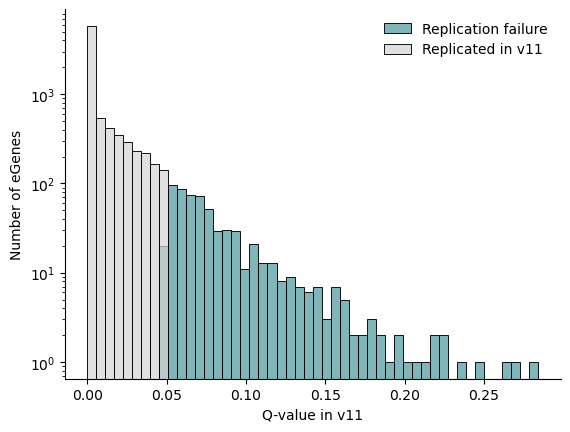

In [170]:
v11_eqtl['replicaiton_failure'] = v11_eqtl['gene_id'].isin(replication_failures['gene_id_v47'])
ax = sns.histplot(v11_eqtl[(v11_eqtl['gene_id'].isin(qtls[qtls['signifigant_e_v10']]['gene_id_v47'])) & (v11_eqtl['gene_id'].isin(qtls_in_both['gene_id_v47']))], x='qval', bins=50, hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)
ax.set_xlabel('Q-value in v11')
ax.set_ylabel('Number of eGenes')
ax.set_yscale('log')


ax.legend(['Replication failure', 'Replicated in v11'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


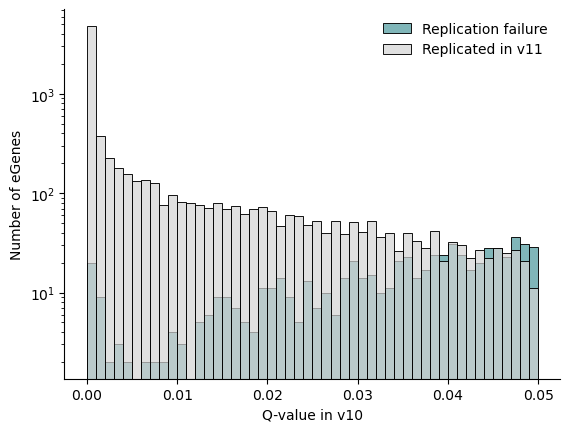

In [171]:
v10_eqtl['replicaiton_failure'] = v10_eqtl['gene_id'].isin(replication_failures['gene_id_v39'])
ax = sns.histplot(v10_eqtl[(v10_eqtl['signifigant']) & (v10_eqtl['gene_id'].isin(qtls_in_both['gene_id_v39']))], x='qval', bins=50, hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)
ax.set_xlabel('Q-value in v10')
ax.set_ylabel('Number of eGenes')
ax.set_yscale('log')


ax.legend(['Replication failure', 'Replicated in v11'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


In [83]:
v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
tpm_v10 = pd.read_csv(v10_quantificaiton_path, sep='\t', skiprows=2)
v10_eqtl = pd.merge(tpm_v10.set_index('Name')[tpm_v10.columns[2:]].median(axis=1.).reset_index(), v10_eqtl, left_on='Name', right_on='gene_id', how='right')

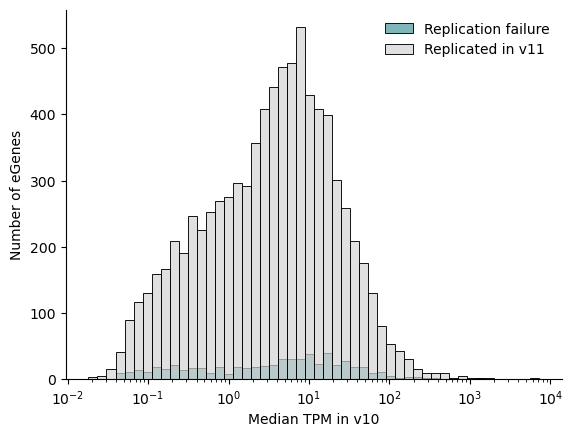

In [84]:
ax = sns.histplot(v10_eqtl[(v10_eqtl['signifigant']) & (v10_eqtl['gene_id'].isin(qtls_in_both['gene_id_v39']))], log_scale=True, x=0, bins=50, hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)

ax.set_xlabel('Median TPM in v10')
ax.set_ylabel('Number of eGenes')

ax.legend(['Replication failure', 'Replicated in v11'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


### how many genes have a qtl?

/local/scratch/klawren/slrmtmp.47807354/ipykernel_17301/591579959.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


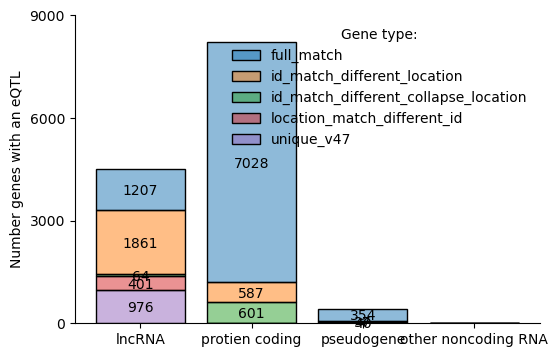

In [172]:
# how many new genes have a QTLs?

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(qtls[qtls['signifigant_e_v11']& ~(qtls['gene_type_grouped'] == 'artifact')], x='gene_type_grouped', hue='match_level',
             multiple='stack', alpha=0.5, shrink=.8, ax=ax)
            # palette=[ '#b70657', '#fb7cb6', 'grey'])

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number genes with an eQTL')
ax.set_yticks([0, 3000, 6000, 9000])

# legend

#ax.legend(['Existing', 'Partial match to v47', 'New in v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)
    

/local/scratch/klawren/slrmtmp.47807354/ipykernel_17301/2147781671.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


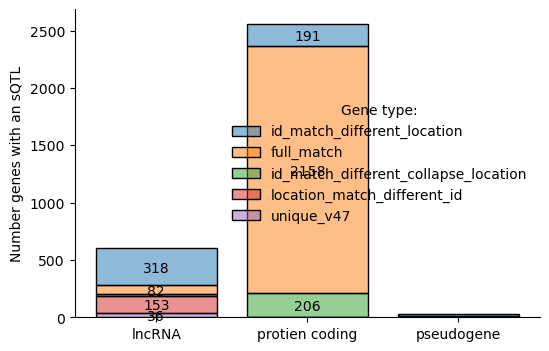

In [173]:
# how many new genes have a QTLs?
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(qtls[qtls['signifigant_s_v11']& ~(qtls['gene_type_grouped'] == 'artifact')], x='gene_type_grouped', hue='match_level',
             multiple='stack', alpha=0.5, shrink=.8, ax=ax)

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number genes with an sQTL')
#ax.set_yticks([0, 3000, 6000, 9000])

# legend

legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)
    

### upset plot of how many genes are eGenes or sGenes

In [198]:
qtls['is_tested_e_v10'] = qtls['gene_id_v39'].isin(v10_eqtl['gene_id'])
qtls['is_tested_e_v11'] = qtls['gene_id_v47'].isin(v11_eqtl['gene_id'])
qtls['is_tested_e'] = qtls['is_tested_e_v11'] | qtls['is_tested_e_v10']
qtls['is_tested_s'] = qtls['gene_id_v39'].isin(v10_sqtl['gene_id']) | qtls['gene_id_v47'].isin(v11_sqtl['gene_id'])
qtls['is_tested'] = qtls['is_tested_e'] | qtls['is_tested_s']
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']

In [175]:
# rename for upset plot
upset_sig_bool = qtls[~(qtls['in_collapsed'] == 'neither') & (qtls['is_hit'])].set_index('signifigant_s_v10').set_index('signifigant_e_v10', append=True).set_index('signifigant_s_v11', append=True).set_index('signifigant_e_v11', append=True)
upset_sig_bool.index.set_names(['v10 sGene', 'v10 eGene', 'v11 sGene', 'v11 eGene'], inplace=True)

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


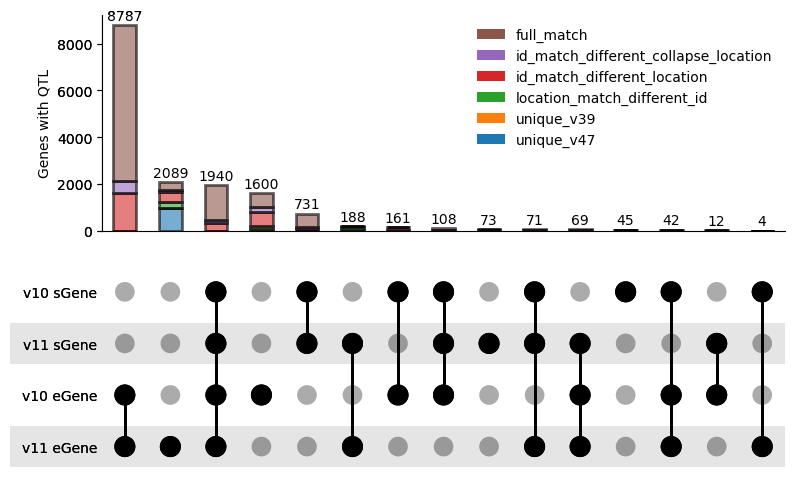

In [176]:
fig = plt.figure(figsize=(10, 6))

upset = up.UpSet(upset_sig_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=1)  # disable the default bar chart
upset.add_stacked_bars(by="match_level", title="", elements=4)
plot_result = upset.plot(fig=fig)


# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel('Genes with QTL')
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# add a legend
#plt.legend(labels=['Location only in v47', 'Location only in v39', 'Location in both,\ndifferent ID', 'ID in both'], bbox_to_anchor=(1.05, 1), loc='upper left', title='ID match level')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()

#### upset plot only for eGenes

of those tested in caudate, how many are egenes in v11 vs v10?

In [256]:
# rename for upset plot
upset_sig_e = qtls[qtls['is_tested_e']].set_index('signifigant_e_v10').set_index('signifigant_e_v11', append=True)
upset_sig_e.index.set_names(['v39', 'v47'], inplace=True)

In [264]:
qtls['sig_label'] = np.where((qtls['signifigant_e_v10']) & (qtls['signifigant_e_v11']), 2, 
                             np.where(qtls['signifigant_e_v11'], 1, 
                                      np.where(qtls['signifigant_e_v10'], 0, 3)))

Text(0.5, 0, 'eGenes\n(signifigant at FDR 5%)')

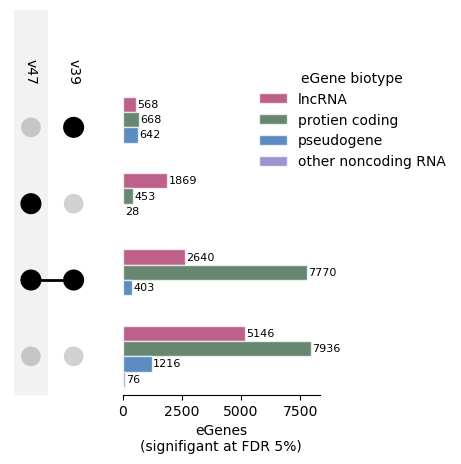

In [301]:
fig = plt.figure(figsize=(4, 5))
upset = up.UpSet(upset_sig_e, intersection_plot_elements=4, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=0, orientation='vertical')  

plot_result = upset.plot(fig=fig)
bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(qtls[(qtls['is_tested_e']) & ~(qtls['gene_type_grouped'] == 'artifact')], y='sig_label', hue='gene_type_grouped', ax=bar_ax, palette=gene_type_pal, hue_order=gene_type_order, alpha=.7, edgecolor='white')

# add numbers to plot
for container in bar_ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    bar_ax.bar_label(container, labels=labels, padding=1, fontsize=8,)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1.7, 1.1), frameon=False, title='eGene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
bar_ax.set_xlabel('eGenes\n(signifigant at FDR 5%)')


### are the eqtls for the new genes new eqtls?

In [ ]:
# p values for other v10 genes for the new gene qlts
new_eqtls = qtls[(qtls['signifigant_e_v11']) & (qtls['match_level'].isin(['unique_v47', 'partial_match']))]

In [37]:
min_pval_nominal=[]
v10_dir_path = 'data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_all_associations'

def get_min_pval_df(v10_dir_path, chr_id):
    v10_nominal_chr = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr{chr_id}.parquet')
    v10_nominal_chr = v10_nominal_chr[v10_nominal_chr['variant_id'].isin(new_eqtls['variant_id_e_v11'])]
    min_pval_idx = v10_nominal_chr.groupby('variant_id')['pval_nominal'].idxmin()
    return v10_nominal_chr.loc[min_pval_idx][['pval_nominal', 'gene_id', 'variant_id']]

for chr_id in tqdm(range(1, 23)):
    min_pval_nominal.append(get_min_pval_df(v10_dir_path, chr_id))
min_pval_nominal.append(get_min_pval_df(v10_dir_path, 'X'))

  0%|          | 0/22 [00:00<?, ?it/s]

In [38]:
new_eqtls = pd.merge(new_eqtls, pd.concat(min_pval_nominal), how='left', left_on='variant_id_e_v11', right_on='variant_id')
print(sum(new_eqtls['pval_nominal'].isna()))
new_eqtls['pval_nominal'] = new_eqtls['pval_nominal'].fillna(1)

# add in the ene type of the gene with the min p value thats closest
new_eqtls = pd.merge(gencode_ids[['gene_id_v39', 'gene_type_grouped']].drop_duplicates('gene_id_v39'), new_eqtls, left_on='gene_id_v39', right_on='gene_id', suffixes=['_v10_min_pval', ''], how='right')

1


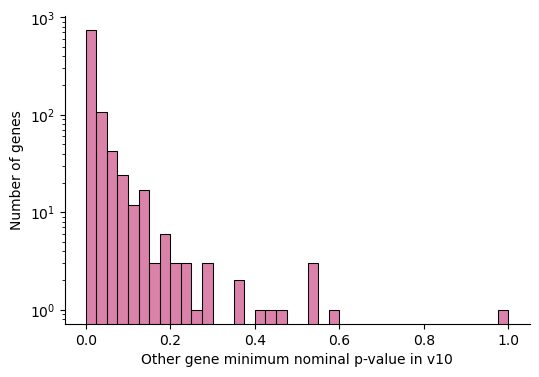

In [39]:
# show the distirbution of minimum p values for all the new qtls
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(new_eqtls, x='pval_nominal', ax=ax, bins=40,
             multiple='dodge', color='#b70657', alpha=.5)
ax.set_yscale('log')
ax.set_xlabel('Other gene minimum nominal p-value in v10')
ax.set_ylabel('Number of genes')
ax.spines[['top', 'right']].set_visible(False)


### p value replicaiton for genes in both

In [ ]:
v10_dir_path = 'data/qtls/GTEx_Analysis_v10_eQTL_all_associations'
v10_nominal = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr20.parquet')

In [ ]:
v11_dir_path = 'output/caudate_analysis/eqtls'
v11_nominal = pd.read_parquet(f'{v11_dir_path}/Brain_Caudate_basal_ganglia.v11.allpairs.chr20.parquet')

In [ ]:
v11_nominal['stable_gene_id'] = v11_nominal['gene_id'].str.split('.').str[0]
v10_nominal['stable_gene_id'] = v10_nominal['gene_id'].str.split('.').str[0]
combined_nominal = pd.merge(v11_nominal, v10_nominal, on=['stable_gene_id', 'variant_id'], how='inner', suffixes=['_v11', '_v10'])

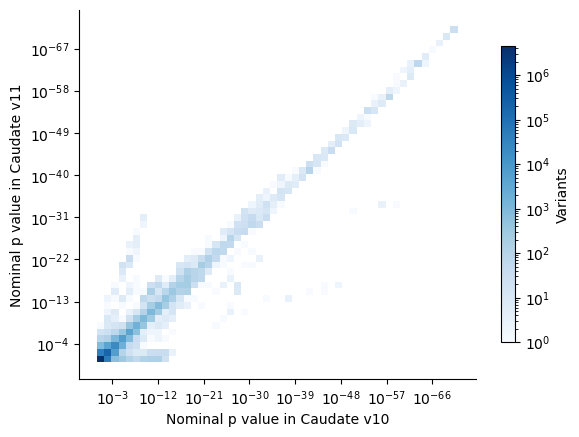

In [ ]:
ax = sns.histplot(combined_nominal, x='pval_nominal_v10', y='pval_nominal_v11', bins=50, norm=LogNorm(), log_scale=True,
                  vmin=None, vmax=None, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Variants'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Nominal p value in Caudate v10')
ax.set_ylabel('Nominal p value in Caudate v11')
ax.invert_xaxis()
ax.invert_yaxis()

combined_nominal['pval_nominal_v10'].corr(combined_nominal['pval_nominal_v11'])
